In [ ]:
!pip install kaggle-environments==1.14.17 numpy pandas seaborn matplotlib

In [2]:
import random
from collections import defaultdict
from math import sqrt, floor
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make

Фиксация генераторов рандомных величин из модулей random и библиотеки numpy

In [3]:
random.seed("rps")
np.random.seed(1452342)

In [ ]:
Создание агентов для игры в камень-ножницы-бумага

In [4]:
def rock_agent(observation, configuration):
    """
    Агент, который всегда играет "камнем"
    """
    return 0


def paper_agent(observation, configuration):
    """
    Агент, который всегда играет "бумагой"
    """
    return 1


def scissors_agent(observation, configuration):
    """
    Агент, который всегда играет "ножницами"
    """
    return 2


def copy_opponent_agent(observation, configuration):
    """
    Агент, который копирует фигуру оппонента на предыдущем ходу. На первом ходу выбирает случайную фигуру
    """
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)


def inversed_copy_opponent_agent(observation, configuration):
    """
    Агент, который выбирает фигуру, бьющую фигуру оппонента на предыдущем шаге
    """
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % configuration.signs
    else:
        return random.randrange(0, configuration.signs)


def strict_order_agent(observation, configuration):
    """
    Агент, который выбирает фигуры в строгом порядке - "камень-бумага-ножницы-камень-бумага..."
    """
    previous_agent_step = observation.step % configuration.signs
    return previous_agent_step


def random_agent(observation, configuration):
    """
    Агент, который на каждом шаге выбирает случайную фигуру
    """
    return random.randrange(0, configuration.signs)


action_map = defaultdict(int)


def adaptive_agent(observation, configuration):
    """
    Агент, который на каждом ходу определяет наиболее часто используемую фигуру и выбирает противоположную ей.
    Пример: если наиболее часто используемая фигура - "камень", то агент выберет бумагу
    """
    if observation.step == 0:
        return 0
    else:
        action_map[observation.lastOpponentAction] += 1
        most_used_action = max(action_map.items(), key=lambda item: item[1])[0]
        opposite_action = (most_used_action + 1) % configuration.signs
        return opposite_action


def random_exclusive_agent(observation, configuration):
    """
    Агент, который выбирает случайную фигуру из списка всех позможных фигур, исключая фигуру оппонента на последнем ходу
    """
    if observation.step == 0:
        return 0
    used_action = observation.lastOpponentAction
    list_of_actions: list[int] = list(range(0, configuration.signs))
    list_of_actions.remove(used_action)
    print(list_of_actions)
    return random.choice(list_of_actions)


def fibonacci_agent(observation, configuration):
    """
    Агент, который определяет n-ое число Фибоначчи на n-ом ходу вычисляет остаток от деления на это число
    """
    def fibonacci(n):
        a, b = 0, 1
        for i in range(n):
            a, b = b, a + b
        return a

    return fibonacci(observation.step) % configuration.signs


def sqrt_agent(observation, configuration):
    """
    Агент, который вычисляет фигуру на n-ном ходу по формуле

    .. math::
        f(n) = floor(\sqrt{n}) % N,
    где :math:`N` - кол-во всех возможных фигур
    """
    return floor(sqrt(observation.step) % configuration.signs)


def poisson_agent(observation, configuration):
    """
    Агент, который определяет n-ное число из распределения Пуассона на n-ном ходу и находит остаток от деления на кол-во возможных фигур
    """
    return int(
        np.random.poisson(configuration.signs, configuration.episodeSteps + 1)[observation.step] % configuration.signs
    )

Определим список соревнующихся агентов

In [5]:
agents = [
    copy_opponent_agent,
    inversed_copy_opponent_agent,
    rock_agent,
    paper_agent,
    scissors_agent,
    strict_order_agent,
    random_agent,
    adaptive_agent,
    random_exclusive_agent,
    fibonacci_agent,
    sqrt_agent,
    poisson_agent
]

Зададим структуру для хранением статистики и инициализруем окружение kaggle-environments

In [6]:
env = make(
    "rps",  # environment to use - no need to change
    configuration={"episodeSteps": 100}  # number of episodes
)
statistic = defaultdict(int)

Определим функции для расчета побед и поражений

In [8]:
def calculate_result_for_agents(action1, action2):
    diff = abs(action1 - action2)
    if diff == 1:
        return action1 - action2
    else:
        return -(action1 - action2) // 2


def process_step_results(steps):
    game_results = tuple(map(lambda step: calculate_result_for_agents(step[0]['action'], step[1]['action']), steps))
    return game_results.count(1), game_results.count(-1)


def format_func_name(name):
    return name.replace("_", "\n")

In [10]:
for pair in itertools.combinations(agents, r=2):
    steps = env.run(pair)
    action_map.clear()
    agent1_wins, agent2_wins = process_step_results(steps)
    print(pair[0].__name__, pair[1].__name__, f'{agent1_wins}:{agent2_wins}')
    statistic[format_func_name(pair[0].__name__)] += agent1_wins
    statistic[format_func_name(pair[1].__name__)] += agent2_wins

statistic_frame = pd.DataFrame(statistic.items(), columns=['agent', 'wins'])
statistic_frame

copy_opponent_agent inversed_copy_opponent_agent 0:50
copy_opponent_agent rock_agent 0:1
copy_opponent_agent paper_agent 0:1
copy_opponent_agent scissors_agent 1:0
copy_opponent_agent strict_order_agent 0:98
copy_opponent_agent random_agent 34:28
copy_opponent_agent adaptive_agent 0:20
copy_opponent_agent random_exclusive_agent 35:30
copy_opponent_agent fibonacci_agent 37:37
copy_opponent_agent sqrt_agent 0:10
copy_opponent_agent poisson_agent 32:23
inversed_copy_opponent_agent rock_agent 98:0
inversed_copy_opponent_agent paper_agent 98:1
inversed_copy_opponent_agent scissors_agent 98:0
inversed_copy_opponent_agent strict_order_agent 0:1
inversed_copy_opponent_agent random_agent 37:32
inversed_copy_opponent_agent adaptive_agent 78:21
inversed_copy_opponent_agent random_exclusive_agent 21:30
inversed_copy_opponent_agent fibonacci_agent 26:36
inversed_copy_opponent_agent sqrt_agent 89:0
inversed_copy_opponent_agent poisson_agent 33:37
rock_agent paper_agent 0:99
rock_agent scissors_agent

,agent,wins
0,copy\nopponent\nagent,388
1,inversed\ncopy\nopponent\nagent,1214
2,rock\nagent,635
3,paper\nagent,630
4,scissors\nagent,617
5,strict\norder\nagent,716
6,random\nagent,728
7,adaptive\nagent,1101
8,random\nexclusive\nagent,911
9,fibonacci\nagent,744


Построим графики для иллюстрации результатов

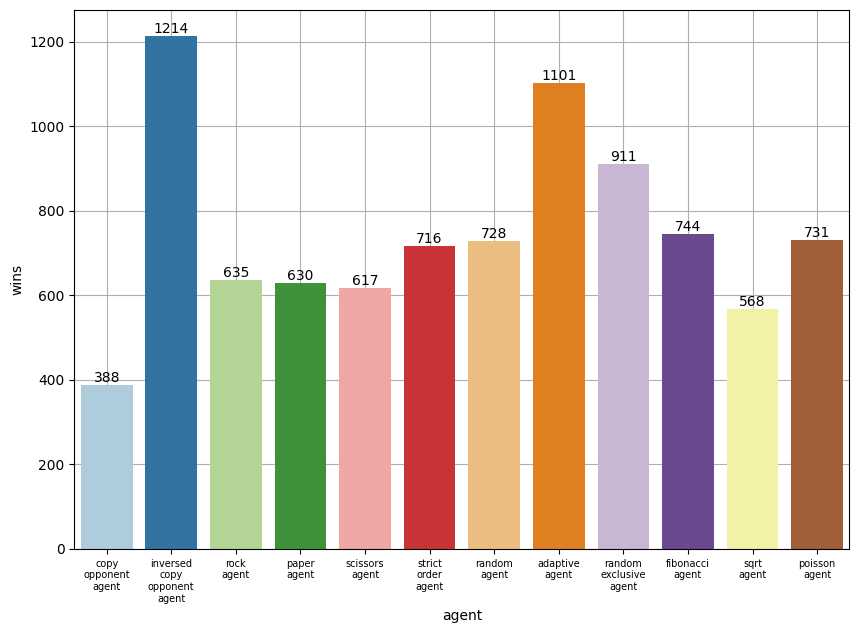

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

ax = sns.barplot(statistic_frame, x='agent', y='wins', hue='agent', palette='Paired', ax=ax)
ax.set_axisbelow(True)
ax.grid(visible=True, linestyle='-', axis='both', zorder=0)
ax.xaxis.set_tick_params(labelsize=7)

for i in ax.containers:
    ax.bar_label(i, )